In [246]:
from bs4 import BeautifulSoup 
import pandas as pd
import numpy as np
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

## Cleaning Data

In [100]:
data = pd.read_csv("airbnb_raw.csv") 

In [101]:
def clean(df):
    df["Room type"] = df["Descriptions"].str.split("in", expand=True)[0]
    df.loc[:, "Guests"] = df["Info"].str.rsplit('guest', 1).str.get(0)
    df.loc[:, "Bedrooms"] = df["Info"].str.split(" · ", n = 0, expand = True)[1].str.rsplit('bedroom', 1).str.get(0)
    df.loc[:, "Beds"] = df.loc[:, "Info"].str.split(" . ", n = 0, expand = True)[2].str.rsplit('bed', 1).str.get(0)
    df.loc[:, "Bathrooms"] = df.loc[:, "Info"].str.split(" . ", n = 0, expand = True)[3]
    df.loc[:,"Price"] = df.loc[:, "Prices"].str.split("$", n = 0, expand = True)[1].str.replace(" / night", "")
    df.loc[:,"Bathrooms"] = df["Bathrooms"].str.rsplit('shared', 1).str.get(0)
    df.loc[:,"Bathrooms"] = df["Bathrooms"].str.rsplit('bath', 1).str.get(0)
    df.loc[:,"Ratings"] = df.loc[:, "Ratings"].str.split(" ", n = 0, expand = True)[1].str.replace(" out of 5;", "")
    df.loc[:, "Reviews"] = df["Review number"].str.rsplit('reviews', 1).str.get(0)
    return df
    

In [102]:
def tonumeric(df):
    df.loc[:, "Guests"] = pd.to_numeric(df.Guests, errors = 'coerce')
    df.loc[:, "Beds"] = pd.to_numeric(df.Beds, errors = 'coerce')
    df.loc[:, "Bedrooms"] = pd.to_numeric(df.Bedrooms, errors = 'coerce')
    df.loc[:, "Bathrooms"] = pd.to_numeric(df.Bathrooms, errors = "coerce")
    df.loc[:, "Ratings"] = pd.to_numeric(df.Ratings, errors = 'coerce')
    df.loc[:, "Price"] = pd.to_numeric(df.Price, errors = 'coerce')
    df.loc[:, "Reviews"] = pd.to_numeric(df.Reviews, errors = 'coerce')
    
    return df

In [103]:
df = clean(data)

In [104]:
df1 = tonumeric(df)

In [105]:
airbnb_data = df1.drop(["Unnamed: 0", "Prices", "Info", "Review number"], axis = 1)

## Data Analysis

## Introduction

This project aims to analyze the data from the website airbnb.com. Airbnb is one of the biggest online platform that allows people to rent out their apartments/rooms/houses to people who are looking for accommodations. 

This projects analyzes the data from 5 cities in the USA, namely New York, Los Angeles, Chicago, San Francisco, Boston. The first three cities are the top 3 cities by populations, San Francisco takes 16th place and Boston - 21st (https://worldpopulationreview.com/us-cities). 

The fist three cities were chosen so that to perform the statistical analysis, and find out is there a significant difference in the mean price of properties among them, and 2 other with singificantly less population, compare with the first three cities. Here the interest lies mainly on answering the questions like: 

    - what features influence the price of the properties: price vs number of guests, price vs number of rooms, price vs number of beds;
    - is there is a significant difference in mean price per night of accommodation among cities?
    - what are the main facility features?



### General overview of the data

In [106]:
airbnb_data.head()

,Names,Descriptions,Facilities,Ratings,Links,City,Room type,Guests,Bedrooms,Beds,Bathrooms,Price,Reviews
0,A single Living Room for rent - null - Brooklyn,Private room in Downtown Brooklyn,Elevator·Wifi·Gym·Airconditioning,NaN,http://airbnb.com/rooms/45789563?previous_page...,New York,Private room,1,1.0,1.0,1.0,32.0,NaN
1,NEW Designer award private BR near G train - n...,Private room in Brooklyn,Wifi·Airconditioning·Kitchen·Washer,NaN,http://airbnb.com/rooms/45793612?previous_page...,New York,Private room,2,1.0,1.0,2.0,45.0,NaN
2,Flatbush Hideaway - Quiet and close to subway!...,Entire house in Flatbush,Wifi·Selfcheck-in·Airconditioning·Kitchen,4.85,http://airbnb.com/rooms/31221559?previous_page...,New York,Entire house,4,1.0,3.0,1.0,39.0,86.0
3,"Friendly, unpretentious, close to the subway -...",Private room in Park Slope,Wifi·Airconditioning·Kitchen,4.91,http://airbnb.com/rooms/23839200?previous_page...,New York,Private room,2,1.0,1.0,1.0,39.0,80.0
4,Spacious private room renovation 2020 - null -...,Private room in Brooklyn,Wifi·Airconditioning·Kitchen·Dishwasher,NaN,http://airbnb.com/rooms/45863833?previous_page...,New York,Private room,1,1.0,1.0,2.0,31.0,NaN


Our dataframe now has 13 columns (variables) and 1500 rows. The variables are 1) categorical - Titles, Descriptions, Facilities, Links, City, Room types; and 2) numerical - number of guests, bedrooms, bathrooms, reviews, ratings, and price. 

In [107]:
print(airbnb_data.shape)

(1500, 13)


Let's obtain some general overview of the data.

In [108]:
print(airbnb_data.columns)
print(airbnb_data.index)

Index(['Names', 'Descriptions', 'Facilities', 'Ratings', 'Links', 'City',
       'Room type', 'Guests', 'Bedrooms', 'Beds', 'Bathrooms', 'Price',
       'Reviews'],
      dtype='object')
RangeIndex(start=0, stop=1500, step=1)


In [109]:
airbnb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 13 columns):
Names           1500 non-null object
Descriptions    1500 non-null object
Facilities      1500 non-null object
Ratings         1073 non-null float64
Links           1500 non-null object
City            1500 non-null object
Room type       1500 non-null object
Guests          1500 non-null int64
Bedrooms        1215 non-null float64
Beds            1473 non-null float64
Bathrooms       1370 non-null float64
Price           1360 non-null float64
Reviews         1073 non-null float64
dtypes: float64(6), int64(1), object(6)
memory usage: 152.4+ KB


In [110]:
airbnb_data['Room type'].unique()

array(['Private room ', 'Entire house ', 'Hotel room ',
       'Entire apartment ', 'Shared room ', 'Entire loft ', 'Room ',
       'Entire condom', 'Entire guest suite ', 'Entire place ',
       'Entire townhouse ', 'Hostel room ', 'Entire guesthouse ',
       'Entire bungalow ', 'Treehouse ', 'Entire cottage ', 'T',
       'Camper/RV ', 'Apartment room ', 'Beds ', 'Boat '], dtype=object)

In [111]:
airbnb_data.isnull().sum()

Names             0
Descriptions      0
Facilities        0
Ratings         427
Links             0
City              0
Room type         0
Guests            0
Bedrooms        285
Beds             27
Bathrooms       130
Price           140
Reviews         427
dtype: int64

We can see that almost one third of the reviews and ratings columns are missing values, also there are missing values in important columns such as price, bedrooms, bathrooms, beds. So these nan values were raw-wisely removed from the dataset in order to conduct more accurate analysis.

In [149]:
airbnb_data = airbnb_data.dropna()
airbnb_data.describe()

,Ratings,Guests,Bedrooms,Beds,Bathrooms,Price,Reviews
count,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000
mean,4.756038,2.685673,1.166667,1.470760,1.274123,79.915205,108.897661
std,0.271651,1.708398,0.457570,1.081195,0.780764,65.169304,122.719018
min,2.830000,1.000000,1.000000,0.000000,0.000000,15.000000,3.000000
25%,4.670000,2.000000,1.000000,1.000000,1.000000,39.000000,17.000000
50%,4.830000,2.000000,1.000000,1.000000,1.000000,63.000000,62.000000
75%,4.930000,4.000000,1.000000,2.000000,1.000000,99.000000,161.500000
max,5.000000,16.000000,4.000000,12.000000,10.000000,741.000000,667.000000


In [188]:
'''overview of the numerical values'''
quantitative = airbnb_data.loc[:,['Price','Ratings','Reviews', 'Guests', 'Bedrooms', 'Beds', 'Bathrooms']]
quantitative.describe()

,Price,Ratings,Reviews,Guests,Bedrooms,Beds,Bathrooms
count,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000
mean,79.915205,4.756038,108.897661,2.685673,1.166667,1.470760,1.274123
std,65.169304,0.271651,122.719018,1.708398,0.457570,1.081195,0.780764
min,15.000000,2.830000,3.000000,1.000000,1.000000,0.000000,0.000000
25%,39.000000,4.670000,17.000000,2.000000,1.000000,1.000000,1.000000
50%,63.000000,4.830000,62.000000,2.000000,1.000000,1.000000,1.000000
75%,99.000000,4.930000,161.500000,4.000000,1.000000,2.000000,1.000000
max,741.000000,5.000000,667.000000,16.000000,4.000000,12.000000,10.000000


## Part 1.
As for now we have a general representation for all five cities, let's look at the data by cities.
In the next few cells we calculate the mean price, rating, number of reviews, number of guests for each of these cities and visualize them using bar charts as follows:

In [187]:
mean_price_nyc = airbnb_data.loc[airbnb_data['City'] == 'New York', 'Price'].mean()
mean_price_la = airbnb_data.loc[airbnb_data['City'] == 'Los Angeles', 'Price'].mean()
mean_price_bst = airbnb_data.loc[airbnb_data['City'] == 'Boston', 'Price'].mean()
mean_price_sf = airbnb_data.loc[airbnb_data['City'] == 'San Francisco', 'Price'].mean()
mean_price_ch = airbnb_data.loc[airbnb_data['City'] == 'Chicago', 'Price'].mean()
print(mean_price_nyc,mean_price_la,mean_price_bst,mean_price_sf,mean_price_ch)

68.87704918032787 87.90259740259741 83.3013698630137 99.57142857142857 62.72


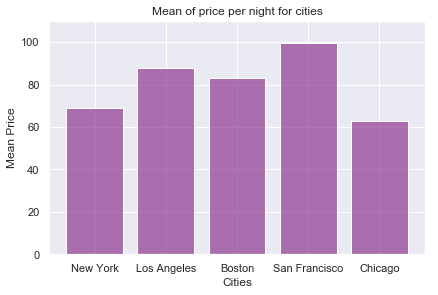

In [279]:
plt.title('Mean of price per night for cities')
plt.xlabel('Cities')
plt.ylabel('Mean Price')
plt.ylim(0,110)

mean_prices = [mean_price_nyc,mean_price_la,mean_price_bst,mean_price_sf,mean_price_ch]
plt.bar(['New York', 'Los Angeles', 'Boston', 'San Francisco', 'Chicago'], mean_prices, color = (0.5,0.1,0.5,0.6))
plt.show()

In [155]:
mean_nrev_nyc = airbnb_data.loc[airbnb_data['City'] == 'New York', 'Reviews'].mean()
mean_nrev_la = airbnb_data.loc[airbnb_data['City'] == 'Los Angeles', 'Reviews'].mean()
mean_nrev_bst = airbnb_data.loc[airbnb_data['City'] == 'Boston', 'Reviews'].mean()
mean_nrev_sf = airbnb_data.loc[airbnb_data['City'] == 'San Francisco', 'Reviews'].mean()
mean_nrev_ch = airbnb_data.loc[airbnb_data['City'] == 'Chicago', 'Reviews'].mean()
print(mean_nrev_nyc,mean_nrev_la,mean_nrev_bst,mean_nrev_sf,mean_nrev_ch)

74.77868852459017 140.33116883116884 110.3972602739726 119.88392857142857 94.71333333333334


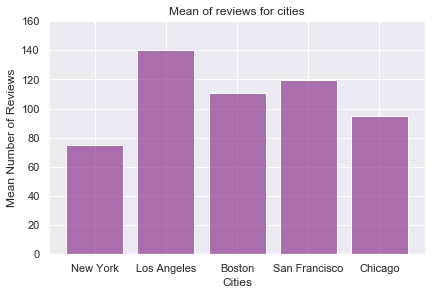

In [278]:
plt.title('Mean of reviews for cities')
plt.xlabel('Cities')
plt.ylabel('Mean Number of Reviews')
plt.ylim(0,160)

mean_nrev = [mean_nrev_nyc,mean_nrev_la,mean_nrev_bst,mean_nrev_sf,mean_nrev_ch]
plt.bar(['New York', 'Los Angeles', 'Boston', 'San Francisco', 'Chicago'], mean_nrev, color = (0.5,0.1,0.5,0.6))
plt.show()

In [157]:
mean_rating_nyc = airbnb_data.loc[airbnb_data['City'] == 'New York', 'Ratings'].mean()
mean_rating_la = airbnb_data.loc[airbnb_data['City'] == 'Los Angeles', 'Ratings'].mean()
mean_rating_bst = airbnb_data.loc[airbnb_data['City'] == 'Boston', 'Ratings'].mean()
mean_rating_sf = airbnb_data.loc[airbnb_data['City'] == 'San Francisco', 'Ratings'].mean()
mean_rating_ch = airbnb_data.loc[airbnb_data['City'] == 'Chicago', 'Ratings'].mean()
print(mean_rating_nyc,mean_rating_la,mean_rating_bst,mean_rating_sf,mean_rating_ch)

4.673688524590165 4.774935064935064 4.737739726027396 4.814821428571429 4.777533333333334


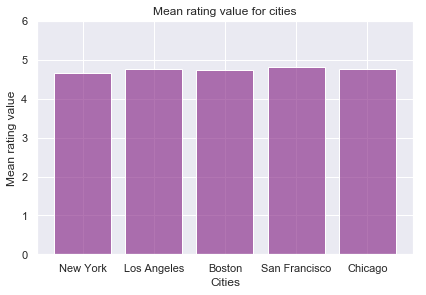

In [280]:
plt.title('Mean rating value for cities')
plt.xlabel('Cities')
plt.ylabel('Mean rating value')
plt.ylim(0,6)

mean_rating = [mean_rating_nyc,mean_rating_la,mean_rating_bst,mean_rating_sf,mean_rating_ch]
plt.bar(['New York', 'Los Angeles', 'Boston', 'San Francisco', 'Chicago'], mean_rating, color = (0.5,0.1,0.5,0.6))
plt.show()

In [198]:
mean_nguests_nyc = airbnb_data.loc[airbnb_data['City'] == 'New York', 'Guests'].mean()
mean_nguests_la = airbnb_data.loc[airbnb_data['City'] == 'Los Angeles', 'Guests'].mean()
mean_nguests_bst = airbnb_data.loc[airbnb_data['City'] == 'Boston', 'Guests'].mean()
mean_nguests_sf = airbnb_data.loc[airbnb_data['City'] == 'San Francisco', 'Guests'].mean()
mean_nguests_ch = airbnb_data.loc[airbnb_data['City'] == 'Chicago', 'Guests'].mean()
print(mean_nguests_nyc,mean_nguests_la,mean_nguests_bst,mean_nguests_sf,mean_nguests_ch)

2.278688524590164 2.538961038961039 2.6232876712328768 2.6160714285714284 3.28


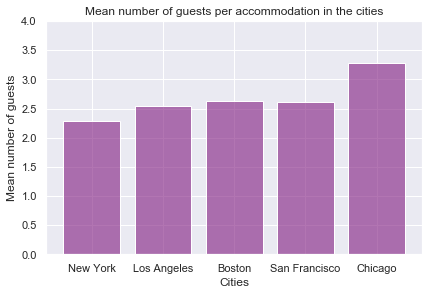

In [281]:
plt.title('Mean number of guests per accommodation in the cities')
plt.xlabel('Cities')
plt.ylabel('Mean number of guests')
plt.ylim(0,4)

mean_nguests = [mean_nguests_nyc,mean_nguests_la,mean_nguests_bst,mean_nguests_sf,mean_nguests_ch]
plt.bar(['New York', 'Los Angeles', 'Boston', 'San Francisco', 'Chicago'], mean_nguests, color = (0.5,0.1,0.5,0.6))
plt.show()

Based on the above calculations and visualizations, we are now interested in investigating more about the price, since there are visible differences between prices, especially regarding Chicago. For this hypothesis testing will be used, namely t test.

## Part 2.
## Hypothesis testing for mean price

1. Is the average price for accommodation on Airbnb in San Francisco more than that in New York City?



$$H_0: \mu_{price\ sf}=\mu_{price\ nyc}, \ H_a:\mu_{price\ sf}>\mu_{price\ nyc}$$
Or equivalently:
$$H_0: \mu_{price\ sf}-\mu_{price\ nyc}=0, \ H_a:\mu_{price\ sf}-\mu_{price\ nyc}>0$$


In [209]:
'''calculating necessary variables'''
st_price_nyc = airbnb_data.loc[airbnb_data['City'] == 'New York', 'Price'].std()
st_price_sf = airbnb_data.loc[airbnb_data['City'] == 'San Francisco', 'Price'].std()
st_price_bst = airbnb_data.loc[airbnb_data['City'] == 'Boston', 'Price'].std()
st_price_la = airbnb_data.loc[airbnb_data['City'] == 'Los Angeles', 'Price'].std()
st_price_ch = airbnb_data.loc[airbnb_data['City'] == 'Chicago', 'Price'].std()
n_ch = airbnb_data.loc[airbnb_data['City'] == 'Chicago', 'Price'].count()
n_la = airbnb_data.loc[airbnb_data['City'] == 'Los Angeles', 'Price'].count()
n_bst = airbnb_data.loc[airbnb_data['City'] == 'Boston', 'Price'].count()
n_nyc = airbnb_data.loc[airbnb_data['City'] == 'New York', 'Price'].count()
n_sf = airbnb_data.loc[airbnb_data['City'] == 'San Francisco', 'Price'].count()

In [216]:
print(n_ch, n_la, n_bst, n_nyc, n_sf)

150 154 146 122 112


In [211]:
from scipy.stats import ttest_ind, ttest_ind_from_stats
t, p = ttest_ind_from_stats(mean_price_ch, st_price_ch, n_ch,
                              mean_price_sf, st_price_sf, n_sf,
                              equal_var=False)
print(t,p)

-4.956669223241324 1.7683518463729987e-06


Since p value is too small and is less than $\alpha = 0.05$, we reject the null hypothesis, thus the average price in San Francisco is indeed higher than in Chicago, which in turn evidently seen from the graph.


Let's conduct another hypothesis testing to compare average prices in San Francisco and Los Angeles, which has the second highest mean price among other cities.

2. Is the average price for accommodation on Airbnb in San Francisco more than that in Los Angeles?



$$H_0: \mu_{price\ sf}=\mu_{price\ la}, \ H_a:\mu_{price\ sf}>\mu_{price\ la}$$
Or equivalently:
$$H_0: \mu_{price\ sf}-\mu_{price\ la}=0, \ H_a:\mu_{price\ sf}-\mu_{price\ la}>0$$

In [206]:
from scipy.stats import ttest_ind, ttest_ind_from_stats
t, p = ttest_ind_from_stats(mean_price_la, st_price_la, n_la,
                              mean_price_sf, st_price_sf, n_sf,
                              equal_var=False)
print(t,p)

-1.2271217112978985 0.22089229271230146


Since p value is greater than $\alpha = 0.05$, we fail to reject the null hypothesis, thus the average price in San Francisco is not higher than in Los Angeles.


So far we looked at San Francisco and Chicago that have the larget difference in mean prices in San Francisco and Los Angeles with the smallest difference, where in bith cities the prices were considerably higher than in other cities.
Similarly, let's test New York City and Chicago, since they have the comparatively lower prices.

3. Is the average price for accommodation on Airbnb in New York more than that in Chicago?

$$H_0: \mu_{price\ nyc}=\mu_{price\ ch}, \ H_a:\mu_{price\ nyc}>\mu_{price\ ch}$$
Or equivalently:
$$H_0: \mu_{price\ nyc}-\mu_{price\ ch}=0, \ H_a:\mu_{price\ nyc}-\mu_{price\ ch}>0$$


In [212]:
from scipy.stats import ttest_ind, ttest_ind_from_stats
t, p = ttest_ind_from_stats(mean_price_nyc, st_price_nyc, n_nyc,
                              mean_price_ch, st_price_ch, n_ch,
                              equal_var=False)
print(t,p)

0.9707511393008693 0.3328188310472435


As expected, since p value is much greater than $\alpha = 0.05$, we fail to reject the null hypothesis, thus the average price in Chicago is not higher than that in New York City.


Let's now look at the boxplot to better summarize the prices across cities.

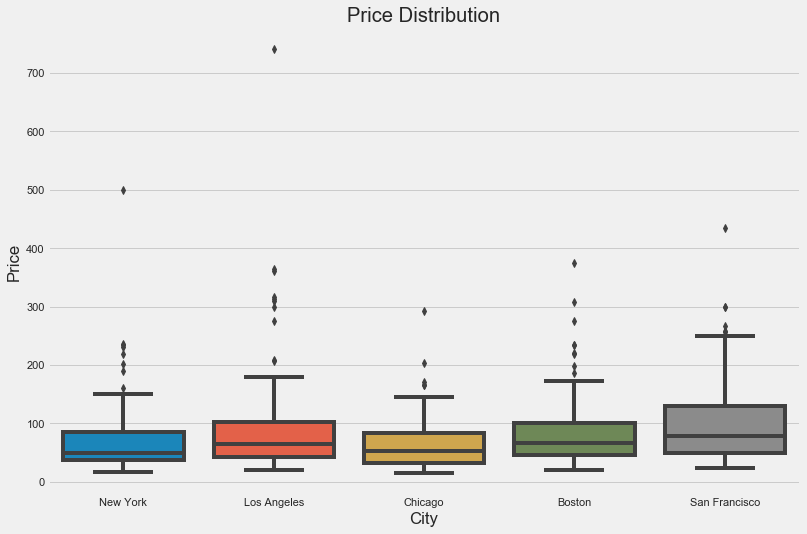

In [217]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
sns.boxplot(y='Price', x='City',data = airbnb_data)
plt.title('Price Distribution')
plt.show()

In [218]:
median_price_nyc = airbnb_data.loc[airbnb_data['City'] == 'New York', 'Price'].median()
median_price_la = airbnb_data.loc[airbnb_data['City'] == 'Los Angeles', 'Price'].median()
median_price_bst = airbnb_data.loc[airbnb_data['City'] == 'Boston', 'Price'].median()
median_price_sf = airbnb_data.loc[airbnb_data['City'] == 'San Francisco', 'Price'].median()
median_price_ch = airbnb_data.loc[airbnb_data['City'] == 'Chicago', 'Price'].median()
print(median_price_nyc, median_price_la, median_price_bst, median_price_sf, median_price_ch)

48.5 65.0 67.0 79.0 52.5


Overall, it can observed that the range of prices in San Francisco is higher, the medians range from 48.5 to 79.
There are also outliers in Los Angeles and New York. The cheapest from all five cities one can find in Chicago.

From this point, let's look at features that affect the price. These are: number of guests that could be accommodated, number of bedrooms, beds, and bathrooms. Ideally, there could be analyzed the area of the accommodation and the location, however this data is cannot be retrieved by using only web scraping.

### Part 3.

Let's look at the correlation between the above-mentioned variables and the price. 

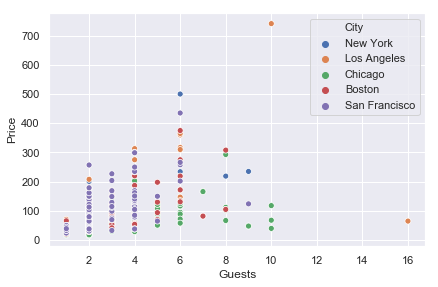

In [234]:
sns.scatterplot(x="Guests", y="Price", data=airbnb_data, hue = airbnb_data['City'])

Let's compute the correlation coefficient as follows:

In [239]:
corr_price_guests = airbnb_data["Price"].corr(airbnb_data["Guests"])
corr_price_guests

0.5212098061738767

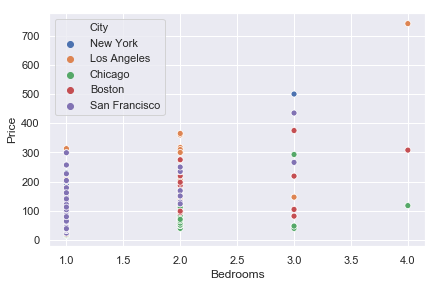

In [235]:
sns.scatterplot(x="Bedrooms", y="Price", data=airbnb_data, hue = airbnb_data['City'])

In [240]:
corr_price_bedrooms = airbnb_data["Price"].corr(airbnb_data["Bedrooms"])
corr_price_bedrooms

0.5097854756120989

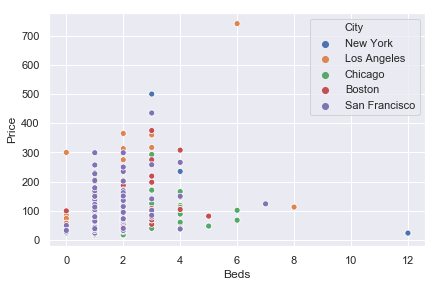

In [238]:
sns.scatterplot(x="Beds", y="Price", data=airbnb_data, hue = airbnb_data['City'])

In [241]:
corr_price_beds = airbnb_data["Price"].corr(airbnb_data["Beds"])
corr_price_beds

0.30309406277712536

Based on these calculations and scatter plots, it can concluded that number of guests and bedrooms have the lower bound of what can be considered as moderately correlated; and number of beds and price have low correlation.
However, if we were given data of longitude and latitude, thus could calculate the correlation between the price and location, meaning that the closer the accommodation is located towards midtown, the higher would be the price, but this is out of scope of this project.

## Part 4.
Here are visualizations for the main room features in the context of cities.

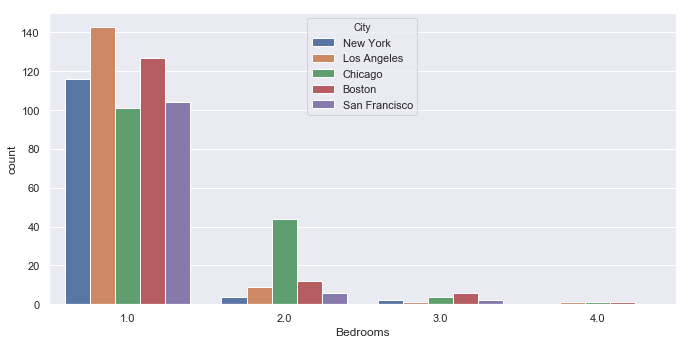

In [242]:
fig_dims = (10, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(style="darkgrid")
ax = sns.countplot(x='Bedrooms', hue=airbnb_data['City'],  data=airbnb_data)
plt.show()

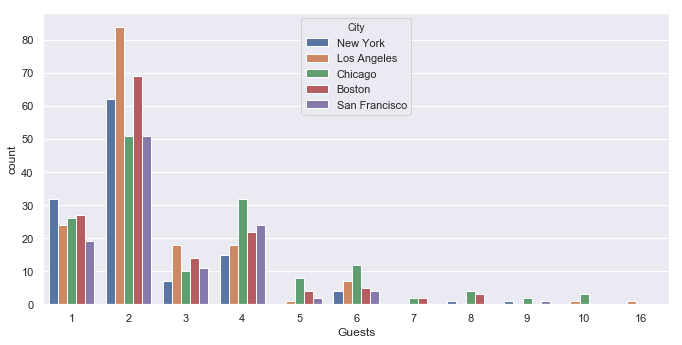

In [175]:
fig_dims = (10, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(style="darkgrid")
ax = sns.countplot(x='Guests', hue=airbnb_data['City'],  data=airbnb_data)
plt.show()

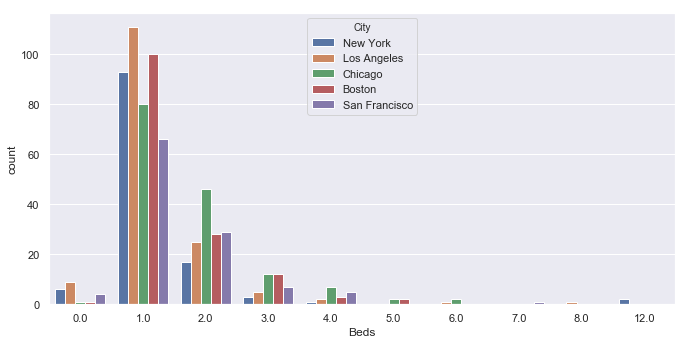

In [176]:
fig_dims = (10, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(style="darkgrid")
ax = sns.countplot(x='Beds', hue=airbnb_data['City'],  data=airbnb_data)
plt.show()

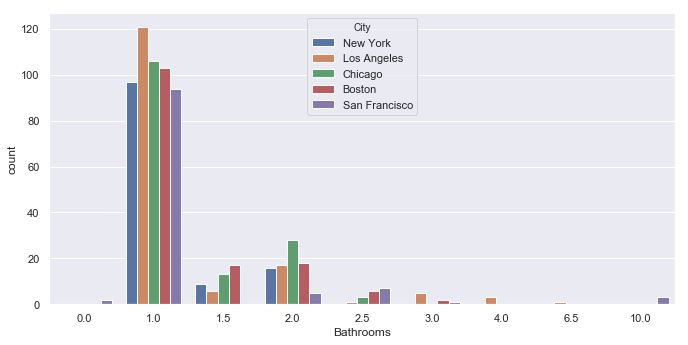

In [177]:
fig_dims = (10, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(style="darkgrid")
ax = sns.countplot(x='Bathrooms', hue=airbnb_data['City'],  data=airbnb_data)
plt.show()

## Part 5.

### Top listing words in Facilities.

In [245]:
words=[]

for i in airbnb_data.Facilities:
    words.append(i)
    
def split_name(word):
    a = str(word).split("·")
    return a

words_count = []

for n in words:
    for k in split_name(n):
        k = k.lower()
        words_count.append(k)

In [251]:
top_facilities = Counter(words_count).most_common()
top_facilitie = top_facilities[:15]

[Text(0, 0, 'wifi'),
 Text(0, 0, 'airconditioning'),
 Text(0, 0, 'kitchen'),
 Text(0, 0, 'selfcheck-in'),
 Text(0, 0, 'washer'),
 Text(0, 0, 'freeparking'),
 Text(0, 0, 'dryer'),
 Text(0, 0, 'elevator'),
 Text(0, 0, 'dishwasher'),
 Text(0, 0, 'heating'),
 Text(0, 0, 'gym'),
 Text(0, 0, 'breakfast'),
 Text(0, 0, 'petsallowed'),
 Text(0, 0, 'indoorfireplace'),
 Text(0, 0, 'hottub'),
 Text(0, 0, 'pool'),
 Text(0, 0, 'beachfront'),
 Text(0, 0, 'waterfront')]

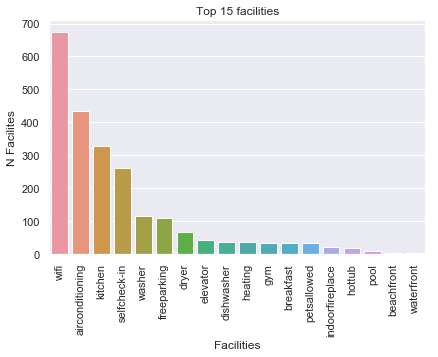

In [252]:
word_data = pd.DataFrame(top_facilities)
word_data.rename(columns={0:'Words',1:'Counts'},inplace=True)
pic = sns.barplot(x='Words',y='Counts', data = word_data)
pic.set_title('Top 15 facilities')
pic.set_ylabel('N Facilites')
pic.set_xlabel('Facilities')
pic.set_xticklabels(pic.get_xticklabels(),rotation = 90)

## Conclusion


In this project I have investigated data obtained from the airbnb.com website for five US cities: New York, Los Angeles, San Francisco, Chicago, Boston. 

After the parsing, there were obtained 1500 rows of data, each city having exactly 300. The main aim was to determine if there is a considerable difference in average price among the cities, and to determine which features affect the price; the general main was to analyze the allocation of features available for the project (rating, number of reviews, number of bedrooms etc.) across these five cities. Before the analysis the NaN values were dropped so that they could not interfere the analysis.

Firstly, I have looked at average values of: price per night, number of reviews, rating, number of guests. So it was revealed that the prices were ranged considerably. In this way, by performing hypothesis testing, it was observed that the prices in San Francisco and Los Angeles were statistically not so different (it was failed to reject that the corresponding means are equal), on contrast we could see that the lowest mean price was observed in Chicago, 62.72 dollars per night and it statistically, again proved by t-test hypothesis, differed from the prices in San Francisco. Also, the same I compared two highest prices among five cities, I compared two lowest out of five, thus Chicago and New York (68.88 dollars), and observed that the mean prices were not statistically different as it was failed to reject the null hypothesis. The results make sense, since the prices for accommodation in San Francisco are considered the highest in the USA (https://www.businessinsider.com/most-expensive-cities-worldwide-to-rent-an-apartment-2019-5#:~:text=Hong%20Kong%20is%20the%20world's,most%20expensive%20in%20the%20US.)

Next thing I was interested in was the correlation of prices with number of guests for which it is suited, number of bedrooms, beds, and bathrooms. The correlation coefficient revealed was not strong, 0.52 and 0.51 respectively for number of guests and number of bedrooms, however it still can tell us there is a slight correlation, but not convincing enough. The correlation between price and number of beds came out to be 0.3 which represents a weak correlation. Here should be noted that besides above-mentioned features, the location is one of the important features for the price setting, and it could be measured by obtaining the longitude and latitude of the place and calculating the distance from the downtown, however, it is out of the scope of this particular project. 

Then the features were analyzed, and it was observed from the appropriate graphs that the mean value of rating was the same throughout the list of cities, however, number of reviews varied considerably, with highest in LA and lowest in NYC. 
Regarding the average number of guests, it composed 2.7 in average, however, in Chicago it is 3.3, which is the only city among others, whose mean number of guests for whom the accommodation is suitable, is higher than 3. In general, across all five countries, according to the graphs in Part 4, accommodation have 1 bedroom, 1 bed, 1 bathroom. In part 5, I analyzed main facilities, and can conclude that all accommodations have Wi-Fi, then comes air-conditioning and kitchen. 

This project used main hypothesis testings, different types of graphs for exploratory data analysis (scatter plot, bar charts, box plots and others). The main limitation was that it was not possible to fully explore features that affect the price such as location; and secondly, there were only 300 items per city available on the website, and moreover, it tends to change as new accommodations appear. This project could be improved by accessing data from http://insideairbnb.com/ that contains a big amount of data for the continuous amount of time, including the bookings, location (longitude, latitude) and many more, so in future a more detailed analysis could be done and even prediction for the prices etc.
